In [14]:
import pandas as pd 
import pandasql as pdspl
import json
from pandas.io.json import json_normalize
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 8]
sns.set()

## Part 1 EDA

In [2]:
#load data and do some general checks
df1=  pd.read_json('logins.json')
display(df1.head())
print('-'*53)
display(df1.info())
print('-'*53)
display(df1.describe())

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


None

-----------------------------------------------------


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


What we notice from the general checks:
* Time period: 1970-01-01 20:12:16 to 1970-04-13 18:57:38
* Count is 93142 and unique is 92265, indicating that there are multiple logins within a single time precised to the seconds. It might be due to logins onto different devices (computers and smart phones at the same time for example).
* It seems a pretty reasonable dataset without further need for cleaning or munging. 

In [3]:
#first let's add 'counts', and set the time as index 
df1['counts'] = 1
df1.set_index(pd.to_datetime(df1.login_time),inplace= True)
df1= df1.resample('15Min').sum()
display(df1.head())
print('-'*53)
#check resampled (15min) data
display(df1.info())
df1.shape

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
counts    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


None

(9788, 1)

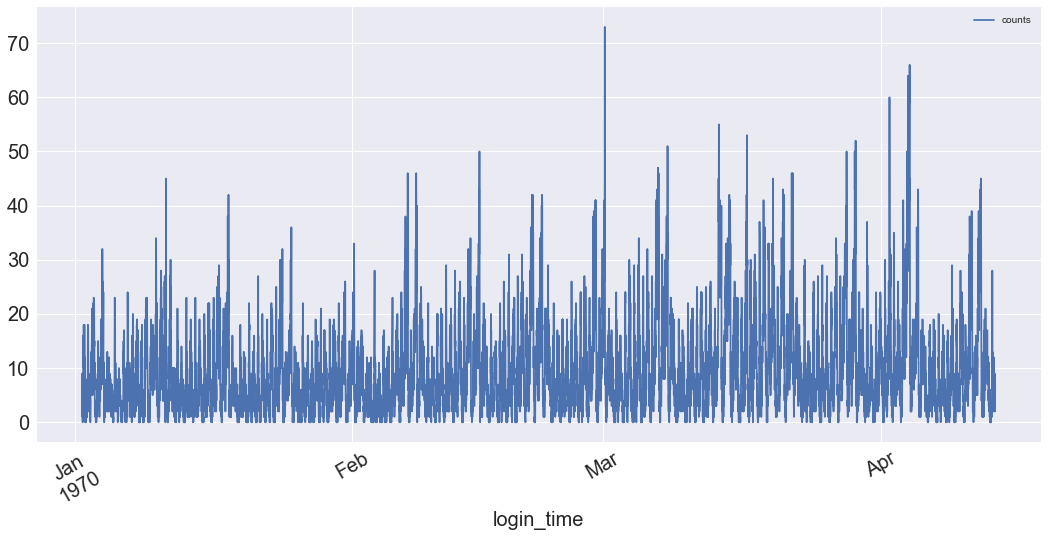

In [15]:
#plot ans see the seasonality and trend if any
df1.plot(fontsize=20)
plt.xlabel('login_time', fontsize=20) 
plt.xticks(rotation= 30);

From the graph above, we can see data points fluctuate a lot: peaking at some point while valleying at others. However, we can't really tell whether what we are observing is really due to seasonality and trend or noise, and there are simply too many data points, so we might want to further smooth out the data.

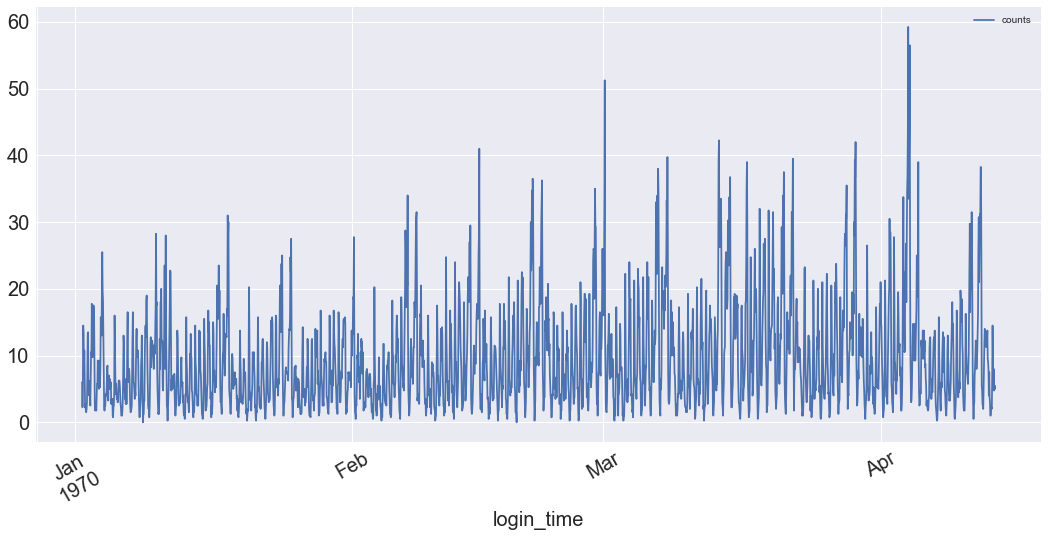

In [16]:
# smooth out by the hour
df1_hr = df1
df1_hr.resample('1h').mean().plot(fontsize=20)
plt.xlabel('login_time', fontsize=20)
plt.xticks(rotation= 30);

After we smooth out the data by the hour, we can still see the peaks and valleys in the data, so we want to do some further smoothing.

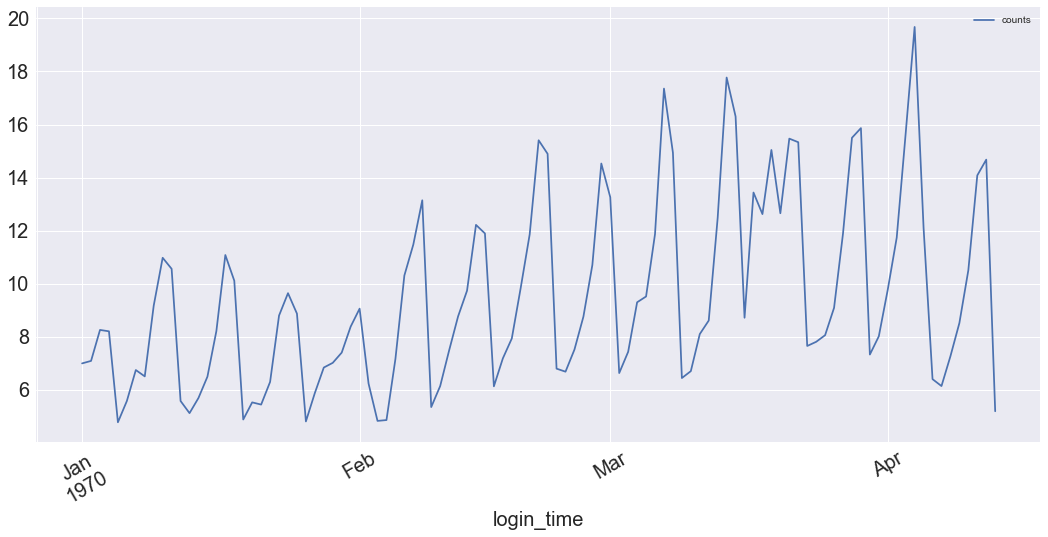

In [17]:
# smooth out by the day
df1_d = df1
df1_d.resample('1D').mean().plot(fontsize=20)
plt.xlabel('login_time', fontsize=20)
plt.xticks(rotation= 30);

After we aggregate the data by day, we can see that there are still fluctuations/cycles, and it seems that overal trend is that data is increasing slowly through mid march and then mildly drops. We will just go further to smooth out the data.

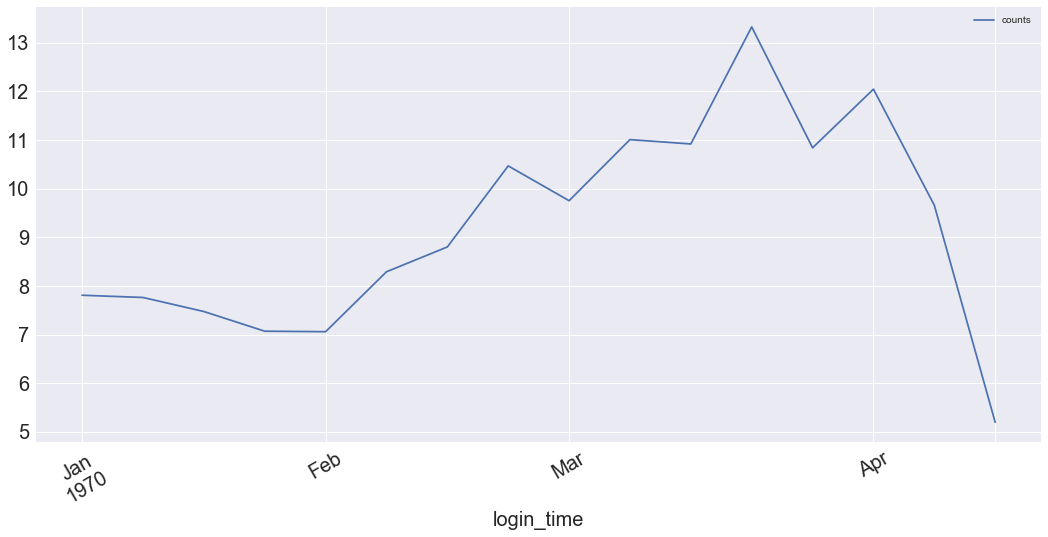

In [18]:
# smooth out by the week
df1_w = df1
df1_d.resample('1W').mean().plot(fontsize=20) 
plt.xlabel('login_time', fontsize=20)
plt.xticks(rotation= 30);

After we aggregate the data weekly, we don't see the seasonality anymore. We can further confirm the trend that we speculated earlier, that the logins counts increases through mid March and drops afterwards. 

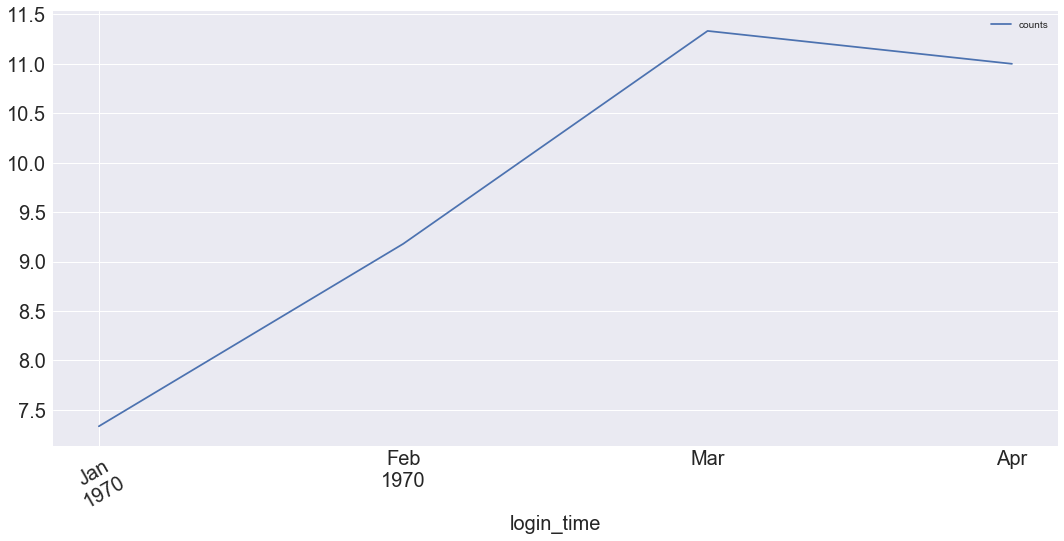

In [19]:
# finally by month
df1_m = df1
df1_m = df1_m.resample('1M').mean()
df1_m.plot(fontsize=20)#figsize=(20,10), linewidth=5,
plt.xlabel('login_time', fontsize=20) 
plt.xticks(rotation= 30);

The graph shows consistent results that we obtained earlier: increases to March and then drops afterwards.

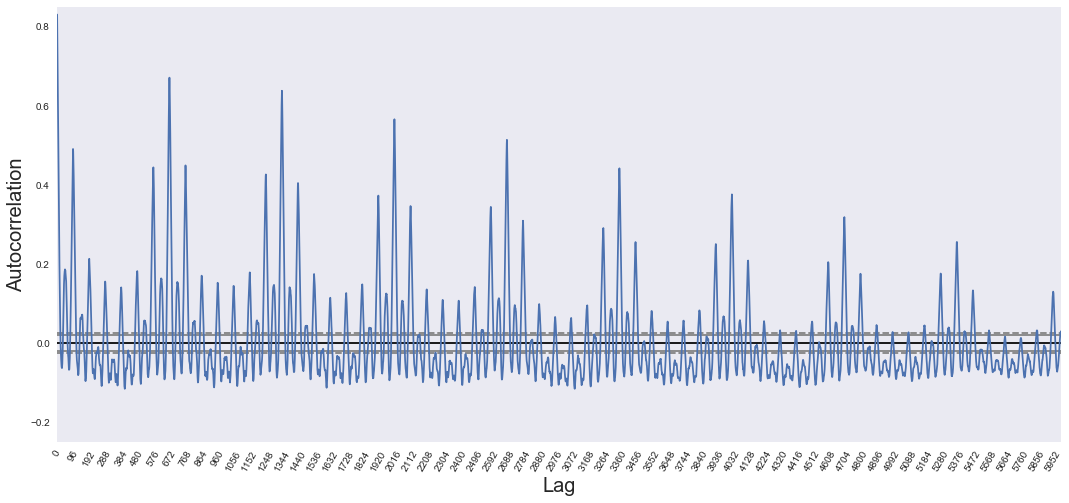

In [20]:
#Check the autocorrelation 
pd.plotting.autocorrelation_plot(df1)
plt.xlabel('Lag', fontsize=20) 
plt.ylabel('Autocorrelation', fontsize=20)
plt.xticks(range(0,9788,96), rotation = 60)
plt.xlim([0, 6000])
plt.ylim([-0.25, 0.85]);

We plot the 15min-aggregated login counts vs. lag here.
Apart from lag 0:
* Data peaks most at laps 672 in correlation, which is basically 672*15/60/24 = 7d. Since the peaks are way outside the dotted line, it means that correlation is statistically significant, and therefore the week periodicity.
* Also noticable peaks are 96, which is basically 96*15/60= 24h. Also the periodicity on a daily basis is also statistically significant.

Since there are confirmed periodicity in weeks and days, we are going to take a closer look at weekly and daily cycles.

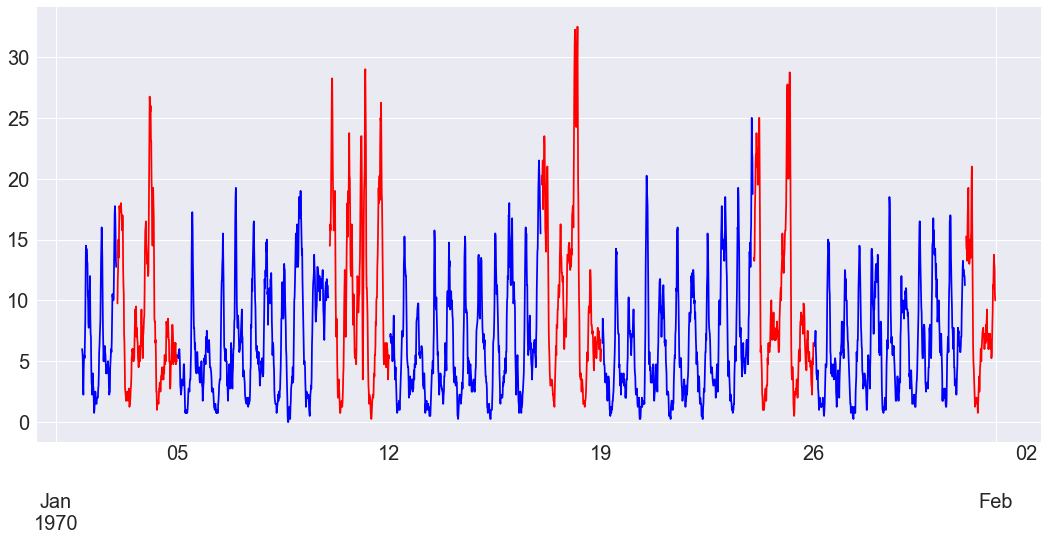

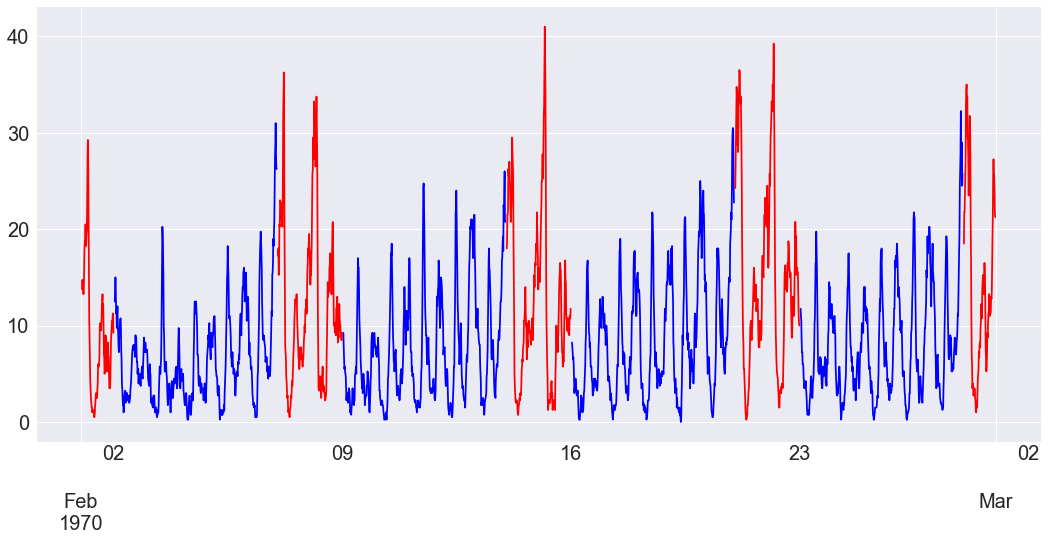

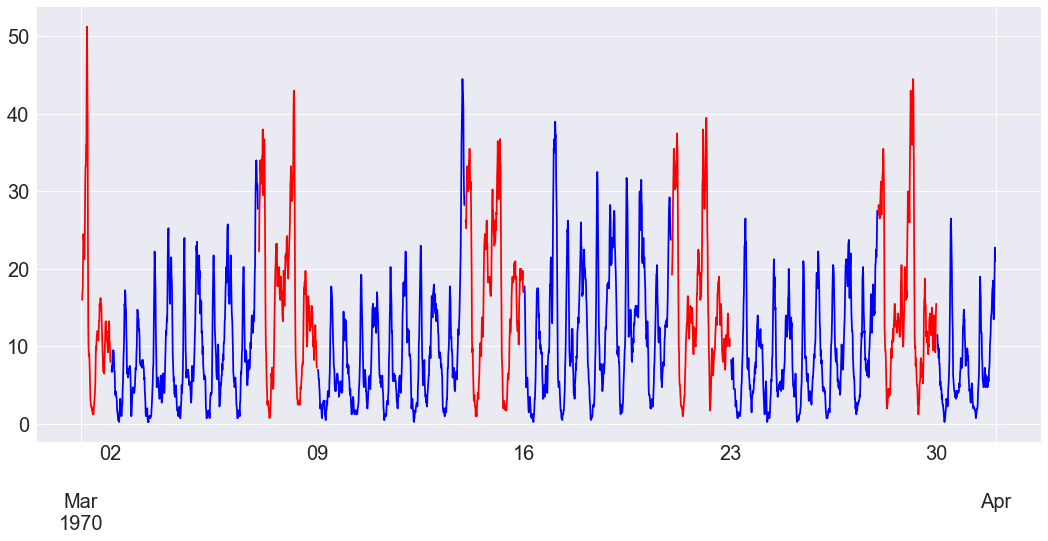

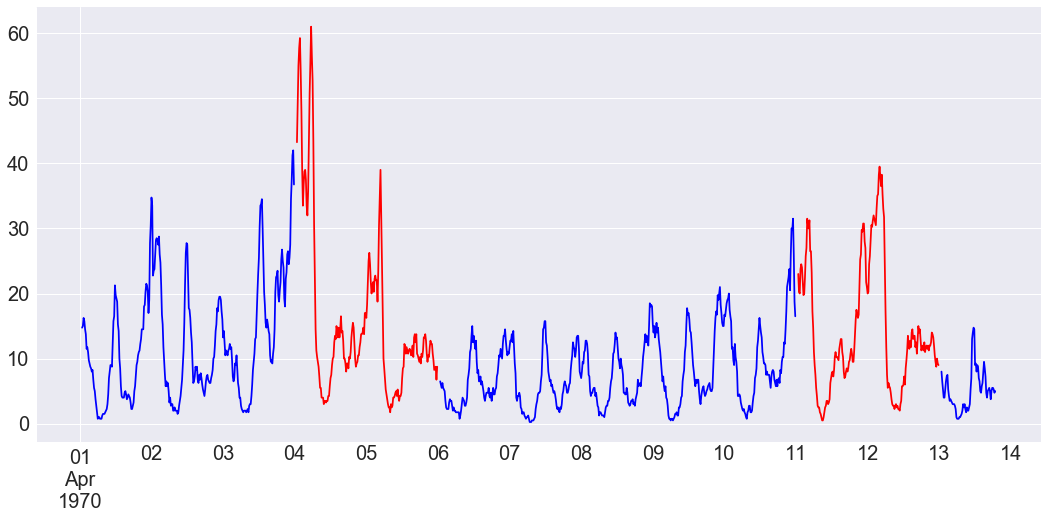

In [21]:
#Now let's check 15min interval for each month, weekday and weekend separately, rolling average on hour 
for i in range(1,5):
    df1_sub = df1.loc[df1.index.month == i] #separates each month 
    temp = df1_sub.reset_index()
    temp['wkd'] = pd.to_datetime(temp.login_time).dt.dayofweek #0: monday ~ 6: sunday
    df1_sub1 = pd.Series(np.where(temp.wkd <=4, df1_sub.counts.values,np.nan), index=df1_sub.index) #weekdays
    df1_sub2 = pd.Series(np.where(temp.wkd > 4, df1_sub.counts.values,np.nan), index=df1_sub.index) #weekends 
    ax = df1_sub1.rolling(4).mean().plot(color = 'b', fontsize =20 )
    df1_sub2.rolling(4).mean().plot(ax=ax,color='r', fontsize = 20)
    plt.xticks(fontsize=20)
    plt.xlabel('')
    plt.show();

For each month, it displays a simialr patterns:
* Weekends have noticable higher logins counts than weekdays 
* Late Fridays have comparable login couns as those of weekends

Finally, we plan to do 2 more analysis: 
* 1.Total aggregation for weekly cycle: based on the day of week; 
* 2.Total aggregation for daily cycle: based on hour of the day, taking into account the differences between weekdays v.s. weekends.

,counts
login_time,
0,8823
1,9268
2,10339
3,11960
4,15208
5,19377
6,18167


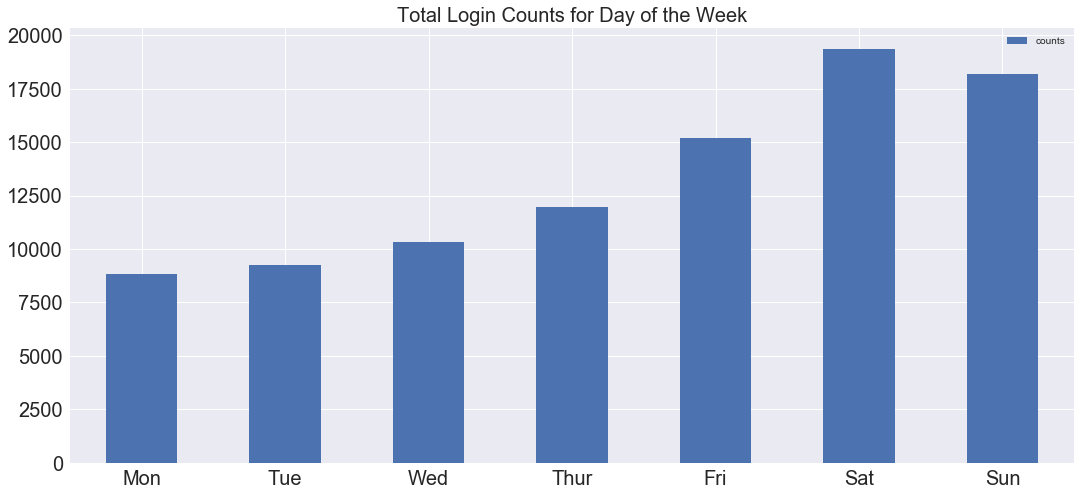

In [22]:
#Aggregate login counts by day of the week from January 1 - April 13
df1_all_wkd = df1.groupby(df1.index.weekday).sum()
display(df1_all_wkd)

# Plot login counts from Mon - Sun
df1_all_wkd.plot(kind='bar', fontsize =20)
plt.title('Total Login Counts for Day of the Week', fontsize =20)
plt.xticks([0,1,2,3,4,5,6],['Mon','Tue', 'Wed','Thur','Fri','Sat','Sun'], rotation = 0)
plt.xlabel('');

### Summary 1

* For the weekly cycles: demands are much higher on Fri, Sat and Sun, with Sat showing the highest demands. Demands from Mon through Thur are slightly increasing, but overall no huge differences.

login_time
0     3616
1     3400
2     2584
3     1610
4     1208
5      750
6      348
7      445
8      538
9     1229
10    2650
11    5135
12    3914
13    2228
14    1875
15    1473
16    1296
17    1325
18    1785
19    1919
20    2789
21    4124
22    4862
23    4495
dtype: int64

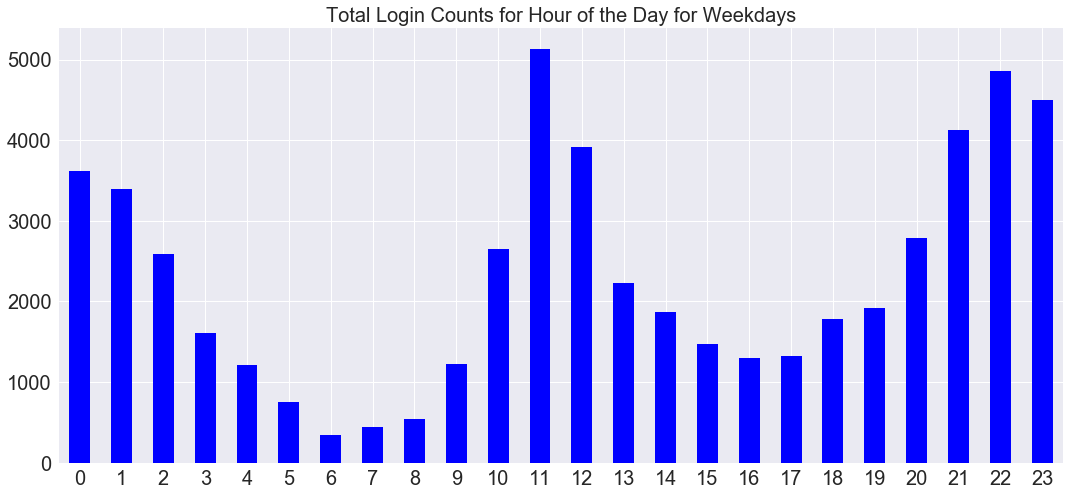

login_time
0     2377
1     2917
2     3216
3     3221
4     3826
5     2195
6      790
7      370
8      280
9      298
10     414
11     664
12    1050
13    1383
14    1551
15    1565
16    1536
17    1259
18    1195
19    1316
20    1314
21    1499
22    1745
23    1563
dtype: int64

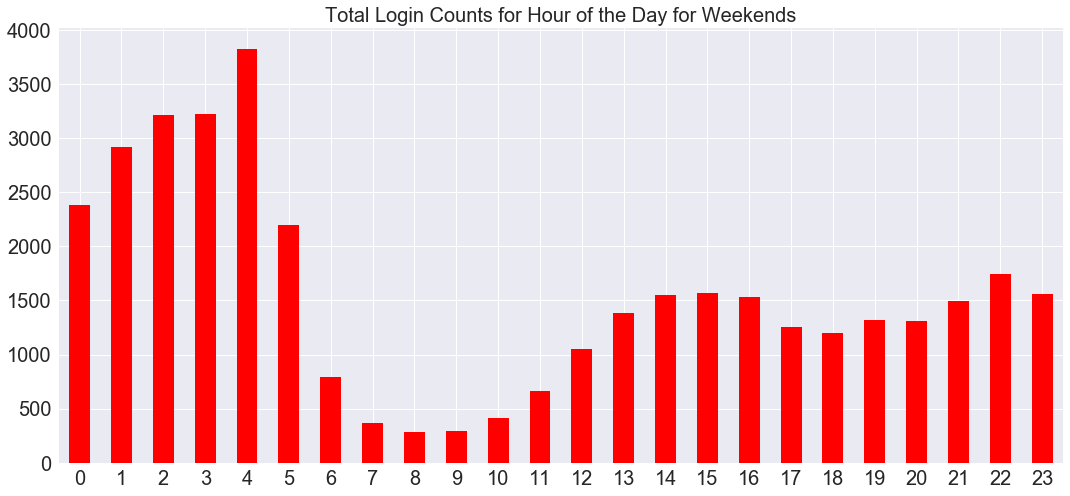

In [23]:
# Create two dataframes for weekdays and weekends 
df1_sub_hr1 = pd.Series(np.where(df1.index.dayofweek <=4, df1.counts.values, 0), index=df1.index) #weekdays
df1_sub_hr2 = pd.Series(np.where(df1.index.dayofweek > 4, df1.counts.values, 0), index=df1.index) #weekends

# Aggregate login counts by hour of the day from January 1 - April 13, weekdays 
df1_wkday_hr = df1_sub_hr1.groupby(df1_sub_hr1.index.hour).sum()
display(df1_wkday_hr)

# Plot login counts by hour
df1_wkday_hr.plot(kind='bar', color= 'blue', fontsize= 20)
plt.title('Total Login Counts for Hour of the Day for Weekdays', fontsize =20)
plt.xticks(rotation = 0)
plt.xlabel('')
plt.show();

# Aggregate login counts by hour of the day from January 1 - April 13, weekdays 
df1_wkend_hr = df1_sub_hr2.groupby(df1_sub_hr2.index.hour).sum()
display(df1_wkend_hr)

# Plot login counts by hour
df1_wkend_hr.plot(kind='bar', color= 'red', fontsize= 20)
plt.title('Total Login Counts for Hour of the Day for Weekends', fontsize =20)
plt.xticks(rotation = 0)
plt.xlabel('');

### Summary 2 

Since there is a weekly cycle as confirmed from prior analysis, we separate the daily analysis for weekdays vs weekends.
* For weekdays: the login counts generally have two peaks: one at noon around 10am-12pm, one at night around 9pm-1am. The demands valleys at 3am-9am, and are low and steady through 1pm-8pm. 
* For weekends: the demands are concentrated in the early mornings around 0-5am, and are lowest around 6am-12am, and flatten out during the rest of the day.